# 3. (20 points)
We are given a dataset containing various criteria important to get admissions into Master’s program and probablity of getting an admit.
Dataset is available at http://preon.iiit.ac.in/~sanjoy_chowdhury/AdmissionDataset.zip

- Q1. Implement a model using linear regression to predict the probablity of getting the admit.(10 points)
- Q2. Compare the performance of **Mean square error loss function** vs **Mean Absolute error function** vs **Mean absolute percentage error function** and explain the reasons for the observed behaviour.(5 points)
- Q3. Analyse and report the behaviour of the coefficients(for example: sign of coefficients, value of coefficients etc.) and support it with appropriate plots as necessary(5 points)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.datatools import inspect_data

In [2]:
def read_csv(file_path):    
    df = pd.read_csv(file_path)

    # we do not need Serial No. column
    df.drop(['Serial No.'], axis=1, inplace=True)

    df = df.rename(columns={"Chance of Admit ": "Chance of Admit"}) 

    return df

df = read_csv("../data/admission/data.csv")

In [3]:
df.head(1)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,317,103,2,2.5,2.0,8.15,0,0.65


# inspect data to get insights


In [4]:
inspect_data(df)
df.info()

GRE Score 49 min: 290 max: 340
------------------
TOEFL Score 29 min: 92 max: 120
------------------
University Rating 5 min: 1 max: 5
[1 2 3 4 5]
[ 28 116 144  95  67]
------------------
SOP 9 min: 1.0 max: 5.0
[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 5 25 40 54 74 79 80 57 36]
------------------
LOR  9 min: 1.0 max: 5.0
[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 1  9 43 47 86 83 83 55 43]
------------------
CGPA 177 min: 7.2 max: 9.92
------------------
Research 2 min: 0 max: 1
[0 1]
[201 249]
------------------
Chance of Admit 60 min: 0.34 max: 0.97
------------------
Datframe size: 450
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 8 columns):
GRE Score            450 non-null int64
TOEFL Score          450 non-null int64
University Rating    450 non-null int64
SOP                  450 non-null float64
LOR                  450 non-null float64
CGPA                 450 non-null float64
Research             450 non-null int64
Chance of Admit  

# Split data into training and validation parts

In [5]:
import random

def train_test_split(X, y, test_size, random_state=None):
    """Splits data into training and testing sets with separate feature and label columns
    test_size must be fractional eg 0.2 for 20% split"""

    if random_state is not None:
        # Seed to generate same pseudo-random numbers everytime to make it reproducible.
        random.seed(random_state)

    test_size = round(test_size * len(X))  # change proportion to actual number of rows

    indices = X.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    X_test = X.loc[test_indices, :]
    y_test = y.loc[test_indices] 
    X_train = X.drop(test_indices)
    y_train = y.drop(test_indices)

    return X_train, X_test, y_train, y_test


In [6]:
X = df.drop(["Chance of Admit"], axis=1)
y = df["Chance of Admit"]

In [7]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=1)

### Add x0 column containing all ones

In [8]:
def add_x0_column(df):
    # add a column for x0 containing all Ones
    df = df.assign(x0=pd.Series(np.ones(len(df))).values)

    # make x0 the first column
    columns = df.columns.tolist()
    columns.remove('x0')
    df = df[['x0'] + columns]
    
    return df


# add a column for x0 containing all Ones
X_train = add_x0_column(X_train)

# add a column for x0 containing all Ones
X_validate = add_x0_column(X_validate)


In [9]:
n = len(X_train.columns) # number of columns
# convert X and y from dataframe to numpy ndarrays
X_train_np = X_train.values
y_train_np = y_train.values
X_validate_np = X_validate.values

y_validate_np = y_validate.values

# make y a vector(1d column) 
y_train_np = np.reshape(y_train_np, (len(y_train_np), 1))

# Q1. Implement a model using linear regression to predict the probablity of getting the admit.


# Using normal equation

In [10]:
def normal_equation(X, y):
    theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T,y)) 
    return theta


def predict(X, theta):
    y_pred = np.matmul(X, theta)[:,0]
    y_pred = np.around(y_pred, decimals=2)
    return y_pred

In [11]:
theta = normal_equation(X_train_np, y_train_np)
y_pred_np = predict(X_validate_np, theta)

from sklearn.metrics import r2_score
r2_score(y_validate_np, y_pred_np)

0.8141678059648589

In [12]:
# adf = pd.DataFrame(y_validate_np, index=range(len(y_validate_np)), columns=["actual"])
# pdf = pd.DataFrame(y_pred_np,  index=range(len(y_validate_np)), columns=["predicted"])

# cdf = pd.concat([adf, pdf],axis=1)

# sns.scatterplot(x="actual", y="predicted", data=cdf,   )

# Q2 Compare the performance of **Mean square error loss function** vs **Mean Absolute error function** vs **Mean absolute percentage error function** 

In [13]:
def mae(y_actual, y_pred):
    n=len(y_actual)
    
    return (1 / n) * np.sum(np.absolute(y_actual - y_pred))


def mse(y_actual, y_pred):
    n=len(y_actual)
    
    return (1 / n) * np.sum((y_actual - y_pred)**2)


def mape(y_actual, y_pred):
    n = len(y_actual)
    return np.sum(abs(y_actual-y_pred) / y_actual) * 100 / n
# Using gradient descent

In [14]:
print("Mean square error:", mse(y_validate_np, y_pred_np))
print("Mean absolute error:", mae(y_validate_np, y_pred_np))
print("Mean absolute percentage error:", f'{mape(y_validate_np, y_pred_np):.2f}%')


Mean square error: 0.0036700000000000005
Mean absolute error: 0.04455555555555556
Mean absolute percentage error: 7.20%


# Q3. Analyse and report the behaviour of the coefficients(for example: sign of coefficients, value of coefficients etc.) and support it with appropriate plots as necessary

GRE Score


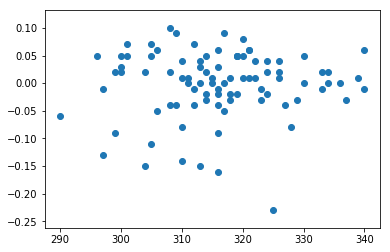

TOEFL Score


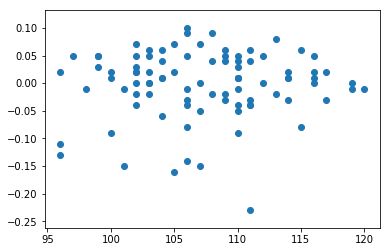

University Rating


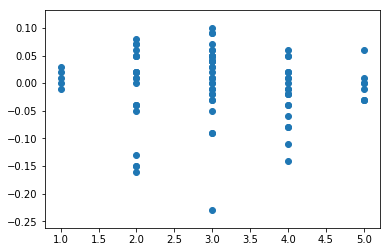

SOP


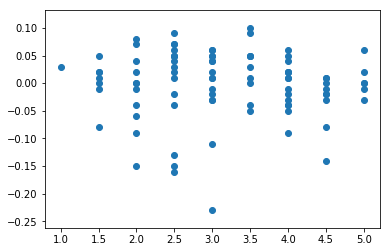

LOR 


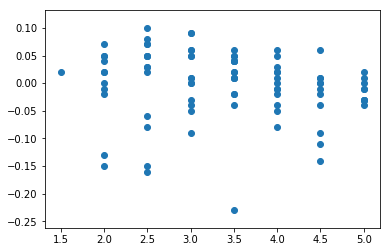

CGPA


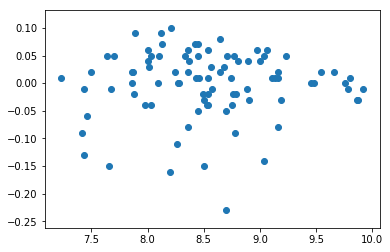

Research


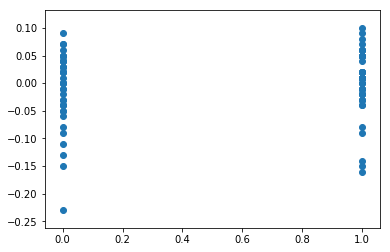

In [15]:
def residual_plot(actual, predicted ,df):
    for col in df:
        if col not in ['Chance of Admit ','x0']:
            print(col)
            plt.scatter(df[col].tolist(), np.subtract(actual, predicted))
            plt.show()
    
residual_plot(y_validate_np, y_pred_np, X_validate)


# Load test data from supplied command line path

In [16]:
import sys
if len(sys.argv) != 2:
    print("Please supply test file path")
    exit(1)

test_file_path = sys.argv[1]
print("Loading test data from:", test_file_path)


Please supply test file path
Loading test data from: -f


In [17]:
# STOPSHIP
if test_file_path == "-f":
    test_file_path = "../data/admission/data.csv"
    
test_df = read_csv(test_file_path)

test_df = add_x0_column(test_df)

X_test = test_df.drop(["Chance of Admit"], axis=1)
y_test = test_df["Chance of Admit"]

y_pred = predict(X_test.values, theta)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8175123215510178

In [18]:
print("Mean square error:", mse(y_test.values, y_pred))
print("Mean absolute error:", mae(y_test.values, y_pred))
print("Mean absolute percentage error:", f'{mape(y_test.values, y_pred):.2f}%')


Mean square error: 0.003640444444444444
Mean absolute error: 0.04297777777777777
Mean absolute percentage error: 6.91%
